In [45]:
from utils import datasets, metrics, core_models, cpd_models, model_utils
from utils.model_utils import fix_seeds

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset

import pytorch_lightning as pl

from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from abc import ABC

import yaml

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Synthetic 1D Data, single model

In [36]:
SEED = 42
fix_seeds(SEED)

In [37]:
experiments_name = "synthetic_1D"
train_dataset, test_dataset = datasets.CPDDatasets(experiments_name=experiments_name).get_dataset_()

In [38]:
# core model for Synthetic 1D
core_model_bce = core_models.BaseRnn(
    input_size=1,
    hidden_dim=4,
    n_layers=1,
    drop_prob=0.5
)

In [39]:
# create dictionary with default arguments for consistency with our interface
# define arguments as they are set in the corresponding config file
learning = dict()
learning["batch_size"] = 64
learning["lr"] = 0.001
learning["epochs"] = 50
learning["grad_clip"] = 0.0

loss = dict()
loss["T"] = 32

args = dict()
args["learning"] = learning
args["loss"] = loss

args["experiments_name"] = experiments_name
args["num_workers"] = 2

In [40]:
# define CPDModel with BCE loss
bce_model = cpd_models.CPDModel(
    loss_type="bce",
    args=args,
    model=core_model_bce,
    train_dataset=train_dataset,
    test_dataset=test_dataset
)

In [41]:
# use logger
model_name = f'seq2seq_bce_seed_{SEED}'
logger = TensorBoardLogger(save_dir=f'logs/{experiments_name}', name=model_name)

# define trainer with custom parameters
trainer = pl.Trainer(
    max_epochs=100,
    accelerator="gpu",
    devices=1,
    benchmark=True,
    check_val_every_n_epoch=1,
    gradient_clip_val=0.,
    logger=logger,
    
    # use early stopping
    callbacks=EarlyStopping(monitor="val_loss", min_delta=0, patience=10)
)

trainer.fit(bce_model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type    | Params
----------------------------------
0 | model | BaseRnn | 117   
1 | loss  | BCELoss | 0     
----------------------------------
117       Trainable params
0         Non-trainable params
117       Total params
0.000     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [13]:
%load_ext tensorboard 
%tensorboard --logdir logs --port 2222

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 2222 (pid 15720), started 0:01:51 ago. (Use '!kill 15720' to kill it.)

In [42]:
# create list of thresholds from [0, 1]
threshold_number = 100
threshold_list = np.linspace(-5, 5, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
threshold_list = [-0.001] + list(threshold_list) + [1.001]

metrics_local, delay_list, fp_delay_list = \
    metrics.evaluation_pipeline(bce_model,
                                bce_model.val_dataloader(),
                                threshold_list,
                                device="cuda", # choose 'cpu' or 'cuda' if available
                                model_type="seq2seq",
                                verbose=True
                               )

  2%|▏         | 1/52 [00:00<00:42,  1.21it/s]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


  4%|▍         | 2/52 [00:01<00:41,  1.20it/s]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


  6%|▌         | 3/52 [00:02<00:40,  1.20it/s]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


  8%|▊         | 4/52 [00:03<00:40,  1.20it/s]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


 10%|▉         | 5/52 [00:04<00:38,  1.21it/s]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


 12%|█▏        | 6/52 [00:04<00:37,  1.22it/s]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


 13%|█▎        | 7/52 [00:05<00:36,  1.23it/s]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


 15%|█▌        | 8/52 [00:06<00:35,  1.23it/s]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


 17%|█▋        | 9/52 [00:07<00:35,  1.22it/s]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


 19%|█▉        | 10/52 [00:08<00:35,  1.20it/s]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


 21%|██        | 11/52 [00:09<00:34,  1.18it/s]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


 23%|██▎       | 12/52 [00:09<00:33,  1.20it/s]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


 25%|██▌       | 13/52 [00:10<00:32,  1.20it/s]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


 27%|██▋       | 14/52 [00:11<00:32,  1.18it/s]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


 29%|██▉       | 15/52 [00:12<00:31,  1.19it/s]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


 31%|███       | 16/52 [00:13<00:30,  1.18it/s]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


 33%|███▎      | 17/52 [00:14<00:29,  1.18it/s]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


 35%|███▍      | 18/52 [00:15<00:28,  1.19it/s]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


 37%|███▋      | 19/52 [00:15<00:27,  1.21it/s]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


 38%|███▊      | 20/52 [00:16<00:26,  1.22it/s]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


 40%|████      | 21/52 [00:17<00:25,  1.23it/s]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


 42%|████▏     | 22/52 [00:18<00:24,  1.22it/s]

TN: 7, FP: 284, FN: 1, TP: 8, DELAY:0.1599999964237213, FP_DELAY:4.730000019073486, COVER: 0.830067138671875


 44%|████▍     | 23/52 [00:19<00:24,  1.19it/s]

TN: 84, FP: 107, FN: 3, TP: 106, DELAY:0.5433333516120911, FP_DELAY:58.80666732788086, COVER: 0.9398053039711719


 46%|████▌     | 24/52 [00:19<00:23,  1.19it/s]

TN: 114, FP: 52, FN: 4, TP: 130, DELAY:0.5799999833106995, FP_DELAY:77.41666412353516, COVER: 0.965951506243062


 48%|████▊     | 25/52 [00:20<00:22,  1.18it/s]

TN: 134, FP: 18, FN: 5, TP: 143, DELAY:0.7666666507720947, FP_DELAY:89.19000244140625, COVER: 0.9803842516775851


 50%|█████     | 26/52 [00:21<00:21,  1.19it/s]

TN: 137, FP: 6, FN: 7, TP: 150, DELAY:1.4266666173934937, FP_DELAY:93.06999969482422, COVER: 0.9884354981468577


 52%|█████▏    | 27/52 [00:22<00:21,  1.17it/s]

TN: 140, FP: 2, FN: 7, TP: 151, DELAY:1.5166666507720947, FP_DELAY:94.663330078125, COVER: 0.9885255239137092


 54%|█████▍    | 28/52 [00:23<00:20,  1.18it/s]

TN: 141, FP: 1, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:127.57333374023438, COVER: 0.8226481119791667


 56%|█████▌    | 29/52 [00:24<00:19,  1.18it/s]

TN: 141, FP: 1, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:127.57333374023438, COVER: 0.8226481119791667


 58%|█████▊    | 30/52 [00:25<00:18,  1.19it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 60%|█████▉    | 31/52 [00:25<00:17,  1.21it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 62%|██████▏   | 32/52 [00:26<00:16,  1.22it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 63%|██████▎   | 33/52 [00:27<00:15,  1.23it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 65%|██████▌   | 34/52 [00:28<00:14,  1.23it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 67%|██████▋   | 35/52 [00:29<00:13,  1.22it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 69%|██████▉   | 36/52 [00:29<00:13,  1.22it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 71%|███████   | 37/52 [00:30<00:12,  1.21it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 73%|███████▎  | 38/52 [00:31<00:11,  1.20it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 75%|███████▌  | 39/52 [00:32<00:10,  1.21it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 77%|███████▋  | 40/52 [00:33<00:10,  1.20it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 79%|███████▉  | 41/52 [00:34<00:09,  1.20it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 81%|████████  | 42/52 [00:34<00:08,  1.21it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 83%|████████▎ | 43/52 [00:35<00:07,  1.21it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 85%|████████▍ | 44/52 [00:36<00:06,  1.22it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 87%|████████▋ | 45/52 [00:37<00:05,  1.23it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 88%|████████▊ | 46/52 [00:38<00:04,  1.23it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 90%|█████████ | 47/52 [00:38<00:04,  1.23it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 92%|█████████▏| 48/52 [00:39<00:03,  1.24it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 94%|█████████▍| 49/52 [00:40<00:02,  1.21it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 96%|█████████▌| 50/52 [00:41<00:01,  1.20it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 98%|█████████▊| 51/52 [00:42<00:00,  1.19it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


100%|██████████| 52/52 [00:43<00:00,  1.20it/s]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667
AUC: 640.27
Time to FA 94.6633, delay detection 1.5167 for best-F1 threshold: 0.5255
TN 140, FP 2, FN 7, TP 151 for best-F1 threshold: 0.5255
Max F1 0.9711: for best-F1 threshold 0.5255
COVER 0.9885: for best-F1 threshold 0.5255
Max COVER 0.9885: for threshold 0.5255


# Ensemble model

In [50]:
class EnsembleCPDModel(ABC):
    """Wrapper for general ensemble models with bootstrapping."""

    def __init__(
        self,
        args: dict,
        n_models: int,
        boot_sample_size: int=None
    ) -> None:
        """Initialize EnsembleCPDModel.

        :param args: dictionary containing core model params, learning params, loss params, etc.
        :param n_models: number of models to train
        :param boot_sample_size: size of the bootstrapped train dataset 
                                 (if None, all the models are trained on the original train dataset)
        """
        super().__init__()
        
        self.args = args
        
        assert args["experiments_name"] in [
            "synthetic_1D", 
            "synthetic_100D",
            "mnist",
            "human_activity",
            "explosion",
            "road_accidents"
        ], "Wrong experiments name"
                
        self.train_dataset, self.test_dataset = datasets.CPDDatasets(
            experiments_name=args["experiments_name"]
        ).get_dataset_()
        
        self.n_models = n_models
        
        if boot_sample_size is not None:
            assert boot_sample_size <= len(self.train_dataset), "Desired sample size is larger than the whole train dataset."
        self.boot_sample_size = boot_sample_size
        
        self.fitted = False

        self.initialize_models_list()

    def eval(self) -> None:
        """Turn all the models to 'eval' mode (for consistency with our code)."""
        for model in self.models_list:
            model.eval()
    
    def to(self, device: str) -> None:
        """Move all models to the device (for consistency with our code)."""
        for model in self.models_list:
            model.to(device) 
        
    def bootstrap_datasets(self) -> None:
        """Generate new train datasets if necessary."""
        # No boostrap
        if self.boot_sample_size is None:
            self.train_datasets_list = [self.train_dataset] * self.n_models
            
        else:
            self.train_datasets_list = []
            for _ in range(self.n_models):
                
                # sample with replacement
                idxs = np.random.choice(range(len(self.train_dataset)), size=self.boot_sample_size)
                curr_train_data = Subset(self.train_dataset, idxs)
                self.train_datasets_list.append(curr_train_data)

    def initialize_models_list(self) -> None:
        """Initialize cpd models for a particular exeriment."""
        self.bootstrap_datasets()

        self.models_list = []
        for i in range(self.n_models):
            curr_model = model_utils.get_models_list(
                self.args,
                self.train_datasets_list[i],
                self.test_dataset
            )[-1] # currently, we do not work with 'combined' models
            self.models_list.append(curr_model)

    def fit(self) -> None:
        """Fit all the models on the corresponding train datasets."""
        if not self.fitted:
            self.initialize_models_list()
            for i, (cpd_model, train_dataset) in enumerate(zip(self.models_list, self.train_datasets_list)):
                print(f'Fitting model number {i+1}.')
                trainer = pl.Trainer(
                    max_epochs=self.args["learning"]["epochs"],
                    accelerator=self.args["learning"]["accelerator"],
                    devices=self.args["learning"]["devices"],
                    benchmark=True,
                    check_val_every_n_epoch=1,
                    callbacks=EarlyStopping(monitor="val_loss", min_delta=0, patience=10)
                )
                trainer.fit(cpd_model)
            
            self.fitted = True
            
        else:
            print("Attention! Models are already fitted!")

    def predict(self, inputs) -> torch.Tensor:
        """Make a prediction.
        
        :param inputs: input batch of sequences
        
        :returns: torch.Tensor containing predictions of all the models
        """
        
        if not self.fitted:
            print("Attention! The model is not fitted yet.")
            
        ensemble_preds = []
        
        for model in self.models_list:
            ensemble_preds.append(model(inputs))
        
        # shape is (n_models, batch_size, seq_len)
        ensemble_preds = torch.stack(ensemble_preds)

        preds_mean = torch.mean(ensemble_preds, axis=0)
        preds_std = torch.std(ensemble_preds, axis=0) 
        
        # store predicted mean and std
        self.preds = ensemble_preds 
        self.preds_mean = preds_mean
        self.preds_std = preds_std
        
        return ensemble_preds

In [51]:
model_type = "seq2seq"
experiments_name = "synthetic_1D"

# read arguments from a default config file
path_to_config = "configs/" + experiments_name + "_" + model_type + ".yaml"

with open(path_to_config, 'r') as f:
    args_config = yaml.safe_load(f.read())

# update args dictionary for con
args_config["experiments_name"] = experiments_name
args_config["model_type"] = model_type
args_config["loss_type"] = "bce"
args_config["num_workers"] = 2

# this has changed in a newer version of PytorchLightning
# if you installed 1.1.6 (as in the requirements.txt), the argument should be: args_config["learning"]["gpus"] = 1
args_config["learning"]["accelerator"] = "gpu"
args_config["learning"]["devices"] = 1
# args_config["learning"]["gpus"] = 1

# set smaller number of epochs
args_config["learning"]["epochs"] = 100

In [48]:
args_config

{'model': {'hidden_dim': 4, 'input_size': 1, 'n_layers': 1, 'drop_prob': 0.5},
 'learning': {'batch_size': 64,
  'lr': 0.001,
  'epochs': 100,
  'grad_clip': 0.0,
  'accelerator': 'gpu',
  'devices': 1},
 'loss': {'T': 32},
 'early_stopping': {'monitor': 'val_loss', 'min_delta': 0, 'patience': 10},
 'experiments_name': 'synthetic_1D',
 'model_type': 'seq2seq',
 'loss_type': 'bce',
 'num_workers': 2}

In [55]:
# If boot_sample_size is not None, bootstrap new train dataset for each model
# Else, train all models on the original train dataset
ens_synth1d_bce = EnsembleCPDModel(args_config, n_models=10, boot_sample_size=300)

In [56]:
ens_synth1d_bce.fit()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type    | Params
----------------------------------
0 | model | BaseRnn | 117   
1 | loss  | BCELoss | 0     
----------------------------------
117       Trainable params
0         Non-trainable params
117       Total params
0.000     Total estimated model params size (MB)


Fitting model number 1.


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type    | Params
----------------------------------
0 | model | BaseRnn | 117   
1 | loss  | BCELoss | 0     
----------------------------------
117       Trainable params
0         Non-trainable params
117       Total params
0.000     Total estimated model params size (MB)


Fitting model number 2.


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type    | Params
----------------------------------
0 | model | BaseRnn | 117   
1 | loss  | BCELoss | 0     
----------------------------------
117       Trainable params
0         Non-trainable params
117       Total params
0.000     Total estimated model params size (MB)


Fitting model number 3.


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type    | Params
----------------------------------
0 | model | BaseRnn | 117   
1 | loss  | BCELoss | 0     
----------------------------------
117       Trainable params
0         Non-trainable params
117       Total params
0.000     Total estimated model params size (MB)


Fitting model number 4.


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type    | Params
----------------------------------
0 | model | BaseRnn | 117   
1 | loss  | BCELoss | 0     
----------------------------------
117       Trainable params
0         Non-trainable params
117       Total params
0.000     Total estimated model params size (MB)


Fitting model number 5.


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type    | Params
----------------------------------
0 | model | BaseRnn | 117   
1 | loss  | BCELoss | 0     
----------------------------------
117       Trainable params
0         Non-trainable params
117       Total params
0.000     Total estimated model params size (MB)


Fitting model number 6.


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type    | Params
----------------------------------
0 | model | BaseRnn | 117   
1 | loss  | BCELoss | 0     
----------------------------------
117       Trainable params
0         Non-trainable params
117       Total params
0.000     Total estimated model params size (MB)


Fitting model number 7.


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type    | Params
----------------------------------
0 | model | BaseRnn | 117   
1 | loss  | BCELoss | 0     
----------------------------------
117       Trainable params
0         Non-trainable params
117       Total params
0.000     Total estimated model params size (MB)


Fitting model number 8.


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type    | Params
----------------------------------
0 | model | BaseRnn | 117   
1 | loss  | BCELoss | 0     
----------------------------------
117       Trainable params
0         Non-trainable params
117       Total params
0.000     Total estimated model params size (MB)


Fitting model number 9.


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type    | Params
----------------------------------
0 | model | BaseRnn | 117   
1 | loss  | BCELoss | 0     
----------------------------------
117       Trainable params
0         Non-trainable params
117       Total params
0.000     Total estimated model params size (MB)


Fitting model number 10.


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


## Create test dataloader

In [57]:
test_dataset = ens_synth1d_bce.test_dataset
test_dataloader = DataLoader(test_dataset, batch_size=64)

## Check results for random sequences

In [59]:
seq_batch, labels_batch = next(iter(test_dataloader))
# seq_bstch has shape (batch_size, seq_len, input_dim)

seq_batch = seq_batch#.to("cuda")

ens_synth1d_bce.predict(seq_batch)
preds_mean, preds_std = ens_synth1d_bce.preds_mean, ens_synth1d_bce.preds_std

Text(0.5, 1.0, 'Sequence')

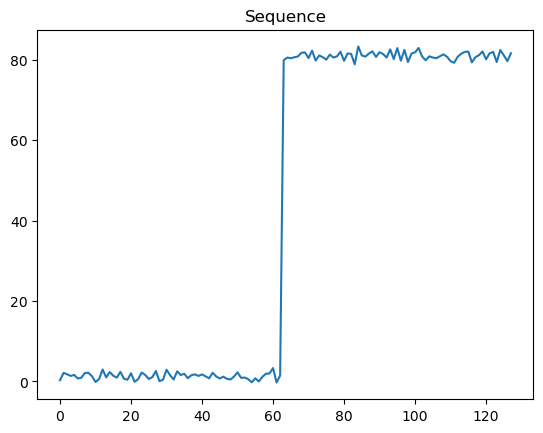

In [60]:
idx = 2
plt.plot(seq_batch[idx].cpu())
plt.title("Sequence")

Text(0.5, 1.0, 'Mean +- std redictions')

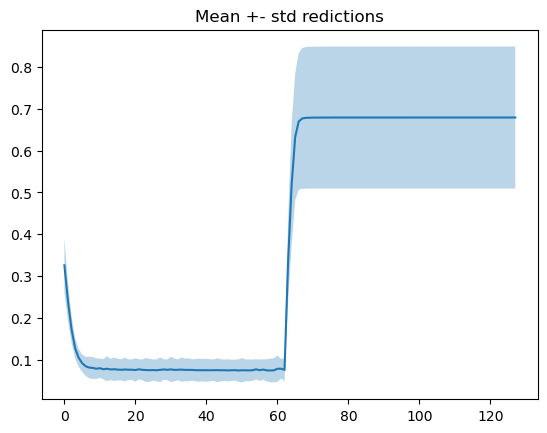

In [61]:
mean = preds_mean[idx].detach().cpu()
std = preds_std[idx].detach().cpu()

plt.plot(mean)
plt.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.3)
plt.title("Mean +- std redictions")

In [62]:
# create list of thresholds from [0, 1]
threshold_number = 100
threshold_list = np.linspace(-5, 5, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
threshold_list = [-0.001] + list(threshold_list) + [1.001]

metrics_local, delay_list, fp_delay_list = \
    metrics.evaluation_pipeline(ens_synth1d_bce,
                                test_dataloader,
                                threshold_list,
                                device="cuda", # choose 'cpu' or 'cuda' if available
                                model_type="ensemble",
                                verbose=True
                               )

  0%|                                                   | 0/102 [00:00<?, ?it/s]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


  1%|▍                                          | 1/102 [00:01<02:47,  1.66s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


  3%|█▎                                         | 3/102 [00:04<02:41,  1.63s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


  4%|█▋                                         | 4/102 [00:06<02:39,  1.62s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667
TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


  5%|██                                         | 5/102 [00:08<02:37,  1.62s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


  6%|██▌                                        | 6/102 [00:09<02:35,  1.62s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


  8%|███▎                                       | 8/102 [00:12<02:31,  1.61s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667
TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


  9%|███▊                                       | 9/102 [00:14<02:29,  1.61s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


 10%|████                                      | 10/102 [00:16<02:28,  1.61s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


 11%|████▌                                     | 11/102 [00:17<02:26,  1.61s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


 12%|████▉                                     | 12/102 [00:19<02:24,  1.61s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


 13%|█████▎                                    | 13/102 [00:21<02:23,  1.61s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


 14%|█████▊                                    | 14/102 [00:22<02:21,  1.61s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


 15%|██████▏                                   | 15/102 [00:24<02:19,  1.61s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


 16%|██████▌                                   | 16/102 [00:25<02:18,  1.61s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


 17%|███████                                   | 17/102 [00:27<02:16,  1.61s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


 18%|███████▍                                  | 18/102 [00:29<02:15,  1.61s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


 19%|███████▊                                  | 19/102 [00:30<02:13,  1.61s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


 20%|████████▏                                 | 20/102 [00:32<02:11,  1.61s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


 21%|████████▋                                 | 21/102 [00:33<02:10,  1.61s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


 22%|█████████                                 | 22/102 [00:35<02:08,  1.61s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


 23%|█████████▍                                | 23/102 [00:37<02:06,  1.61s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


 24%|█████████▉                                | 24/102 [00:38<02:05,  1.61s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


 25%|██████████▎                               | 25/102 [00:40<02:03,  1.61s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


 25%|██████████▋                               | 26/102 [00:41<02:02,  1.61s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


 26%|███████████                               | 27/102 [00:43<02:00,  1.61s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


 27%|███████████▌                              | 28/102 [00:45<01:59,  1.61s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


 28%|███████████▉                              | 29/102 [00:46<01:57,  1.61s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


 29%|████████████▎                             | 30/102 [00:48<01:55,  1.61s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


 30%|████████████▊                             | 31/102 [00:49<01:54,  1.61s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


 31%|█████████████▏                            | 32/102 [00:51<01:52,  1.61s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


 33%|██████████████                            | 34/102 [00:54<01:49,  1.61s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667
TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


 34%|██████████████▍                           | 35/102 [00:56<01:48,  1.61s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


 35%|██████████████▊                           | 36/102 [00:58<01:46,  1.61s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


 36%|███████████████▏                          | 37/102 [00:59<01:44,  1.61s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


 37%|███████████████▋                          | 38/102 [01:01<01:43,  1.61s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


 38%|████████████████                          | 39/102 [01:02<01:41,  1.61s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


 39%|████████████████▍                         | 40/102 [01:04<01:40,  1.61s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


 40%|████████████████▉                         | 41/102 [01:06<01:38,  1.61s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


 41%|█████████████████▎                        | 42/102 [01:07<01:36,  1.61s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


 42%|█████████████████▋                        | 43/102 [01:09<01:35,  1.61s/it]

TN: 0, FP: 300, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.8226481119791667


 43%|██████████████████                        | 44/102 [01:10<01:33,  1.61s/it]

TN: 97, FP: 91, FN: 3, TP: 109, DELAY:0.9366666674613953, FP_DELAY:65.33333587646484, COVER: 0.9364362648341732


 44%|██████████████████▌                       | 45/102 [01:12<01:31,  1.61s/it]

TN: 119, FP: 42, FN: 5, TP: 134, DELAY:1.2599999904632568, FP_DELAY:80.8933334350586, COVER: 0.9632606892709779


 46%|███████████████████▎                      | 47/102 [01:15<01:28,  1.62s/it]

TN: 135, FP: 16, FN: 6, TP: 143, DELAY:1.5766667127609253, FP_DELAY:90.21333312988281, COVER: 0.9734798660184333
TN: 140, FP: 5, FN: 6, TP: 149, DELAY:1.6399999856948853, FP_DELAY:94.04000091552734, COVER: 0.9792307454231026


 47%|███████████████████▊                      | 48/102 [01:17<01:27,  1.63s/it]

TN: 142, FP: 0, FN: 7, TP: 151, DELAY:2.0333333015441895, FP_DELAY:95.51667022705078, COVER: 0.9806470602430558


 49%|████████████████████▌                     | 50/102 [01:20<01:24,  1.62s/it]

TN: 142, FP: 0, FN: 7, TP: 151, DELAY:2.049999952316284, FP_DELAY:95.51667022705078, COVER: 0.9804623089392787
TN: 142, FP: 0, FN: 8, TP: 150, DELAY:2.366666555404663, FP_DELAY:95.80000305175781, COVER: 0.9786210525150949


 50%|█████████████████████                     | 51/102 [01:22<01:22,  1.62s/it]

TN: 142, FP: 0, FN: 8, TP: 150, DELAY:2.7033333778381348, FP_DELAY:95.80000305175781, COVER: 0.9741091034936541


 51%|█████████████████████▍                    | 52/102 [01:23<01:20,  1.62s/it]

TN: 142, FP: 0, FN: 9, TP: 149, DELAY:2.9100000858306885, FP_DELAY:95.8066635131836, COVER: 0.9717987808137624


 52%|█████████████████████▊                    | 53/102 [01:25<01:19,  1.62s/it]

TN: 142, FP: 0, FN: 10, TP: 148, DELAY:3.123333215713501, FP_DELAY:95.8133316040039, COVER: 0.9708830664546224


 53%|██████████████████████▏                   | 54/102 [01:27<01:17,  1.61s/it]

TN: 142, FP: 0, FN: 13, TP: 145, DELAY:3.366666555404663, FP_DELAY:96.34666442871094, COVER: 0.9689350443783433


 54%|██████████████████████▋                   | 55/102 [01:28<01:15,  1.61s/it]

TN: 142, FP: 0, FN: 15, TP: 143, DELAY:3.7066667079925537, FP_DELAY:96.82333374023438, COVER: 0.9678908465432985


 55%|███████████████████████                   | 56/102 [01:30<01:14,  1.61s/it]

TN: 142, FP: 0, FN: 17, TP: 141, DELAY:3.9833333492279053, FP_DELAY:96.96666717529297, COVER: 0.9640913681978308


 57%|███████████████████████▉                  | 58/102 [01:33<01:11,  1.62s/it]

TN: 142, FP: 0, FN: 17, TP: 141, DELAY:4.246666431427002, FP_DELAY:96.96666717529297, COVER: 0.9602799889041224


 58%|████████████████████████▎                 | 59/102 [01:35<01:09,  1.62s/it]

TN: 142, FP: 0, FN: 154, TP: 4, DELAY:32.189998626708984, FP_DELAY:126.3133316040039, COVER: 0.8223996853298612
TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 59%|████████████████████████▋                 | 60/102 [01:36<01:07,  1.62s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 60%|█████████████████████████                 | 61/102 [01:38<01:06,  1.61s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 61%|█████████████████████████▌                | 62/102 [01:40<01:04,  1.61s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 62%|█████████████████████████▉                | 63/102 [01:41<01:02,  1.61s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 63%|██████████████████████████▎               | 64/102 [01:43<01:01,  1.61s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 64%|██████████████████████████▊               | 65/102 [01:44<00:59,  1.61s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 65%|███████████████████████████▏              | 66/102 [01:46<00:58,  1.61s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 66%|███████████████████████████▌              | 67/102 [01:48<00:56,  1.61s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 67%|████████████████████████████              | 68/102 [01:49<00:54,  1.61s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 68%|████████████████████████████▍             | 69/102 [01:51<00:53,  1.61s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 69%|████████████████████████████▊             | 70/102 [01:52<00:51,  1.61s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 70%|█████████████████████████████▏            | 71/102 [01:54<00:49,  1.61s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 71%|█████████████████████████████▋            | 72/102 [01:56<00:48,  1.61s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 72%|██████████████████████████████            | 73/102 [01:57<00:46,  1.61s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 73%|██████████████████████████████▍           | 74/102 [01:59<00:45,  1.61s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 74%|██████████████████████████████▉           | 75/102 [02:00<00:43,  1.61s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 75%|███████████████████████████████▎          | 76/102 [02:02<00:41,  1.61s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 75%|███████████████████████████████▋          | 77/102 [02:04<00:40,  1.61s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 76%|████████████████████████████████          | 78/102 [02:05<00:38,  1.61s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 77%|████████████████████████████████▌         | 79/102 [02:07<00:37,  1.61s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 78%|████████████████████████████████▉         | 80/102 [02:09<00:35,  1.61s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 79%|█████████████████████████████████▎        | 81/102 [02:10<00:33,  1.62s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 80%|█████████████████████████████████▊        | 82/102 [02:12<00:32,  1.61s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 81%|██████████████████████████████████▏       | 83/102 [02:13<00:30,  1.61s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 82%|██████████████████████████████████▌       | 84/102 [02:15<00:29,  1.61s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 83%|███████████████████████████████████       | 85/102 [02:17<00:27,  1.61s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 84%|███████████████████████████████████▍      | 86/102 [02:18<00:25,  1.61s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 85%|███████████████████████████████████▊      | 87/102 [02:20<00:24,  1.61s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 87%|████████████████████████████████████▋     | 89/102 [02:23<00:21,  1.62s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 88%|█████████████████████████████████████     | 90/102 [02:25<00:19,  1.63s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667
TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 90%|█████████████████████████████████████▉    | 92/102 [02:28<00:16,  1.62s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 91%|██████████████████████████████████████▎   | 93/102 [02:30<00:14,  1.62s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667
TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 93%|███████████████████████████████████████   | 95/102 [02:33<00:11,  1.61s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667
TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 95%|███████████████████████████████████████▉  | 97/102 [02:36<00:08,  1.61s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 96%|████████████████████████████████████████▎ | 98/102 [02:38<00:06,  1.61s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 97%|████████████████████████████████████████▊ | 99/102 [02:39<00:04,  1.61s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 98%|████████████████████████████████████████▏| 100/102 [02:41<00:03,  1.61s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


 99%|████████████████████████████████████████▌| 101/102 [02:42<00:01,  1.61s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667


100%|█████████████████████████████████████████| 102/102 [02:44<00:00,  1.61s/it]

TN: 142, FP: 0, FN: 158, TP: 0, DELAY:33.81999969482422, FP_DELAY:128.0, COVER: 0.8226481119791667
AUC: 664.7213
Time to FA 95.5167, delay detection 2.0333 for best-F1 threshold: 0.4372
TN 142, FP 0, FN 7, TP 151 for best-F1 threshold: 0.4372
Max F1 0.9773: for best-F1 threshold 0.4372
COVER 0.9806: for best-F1 threshold 0.4372
Max COVER 0.9806: for threshold 0.4372
